This notebook demonstrates the most important steps how to use **LayoutLMv3** model on **IstVoices** dataset. Covered topics are:
- Convert the raw data (images, annotations) into a *general* dataset  
- Prepare the *general* Istvoices dataset for the model
- Fine-tune the model on the *prepared* dataset
- Evaluate the model quantitatively
- Visualize a prediction

### Convert the raw data (images, annotations) into a *general* dataset 

In [1]:
from datasets import load_dataset

# Load the custom dataset (or it if it does not exist)
# Param 1: location of the dataset loader script
# Param 2: location of cache folder, where the dataset will be saved
dataset = load_dataset(r'C:\Users\Habram\Documents\thesis-masters\invoice_generation\istvoices_dataset.py', cache_dir=r'C:\Users\Habram\.cache')

Found cached dataset istvoices_dataset (C:/Users/Habram/.cache/istvoices_dataset/default/0.0.0/07bb159fcd7e5fd88962d0d6ca202549a4212b7b1caa7b79cc7108797eb8d1c0)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
# The dataset has two splits: train and test
# Each example has the following features: 'id', 'tokens', 'bboxes', 'ner_tags', 'image'
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 150
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 50
    })
})

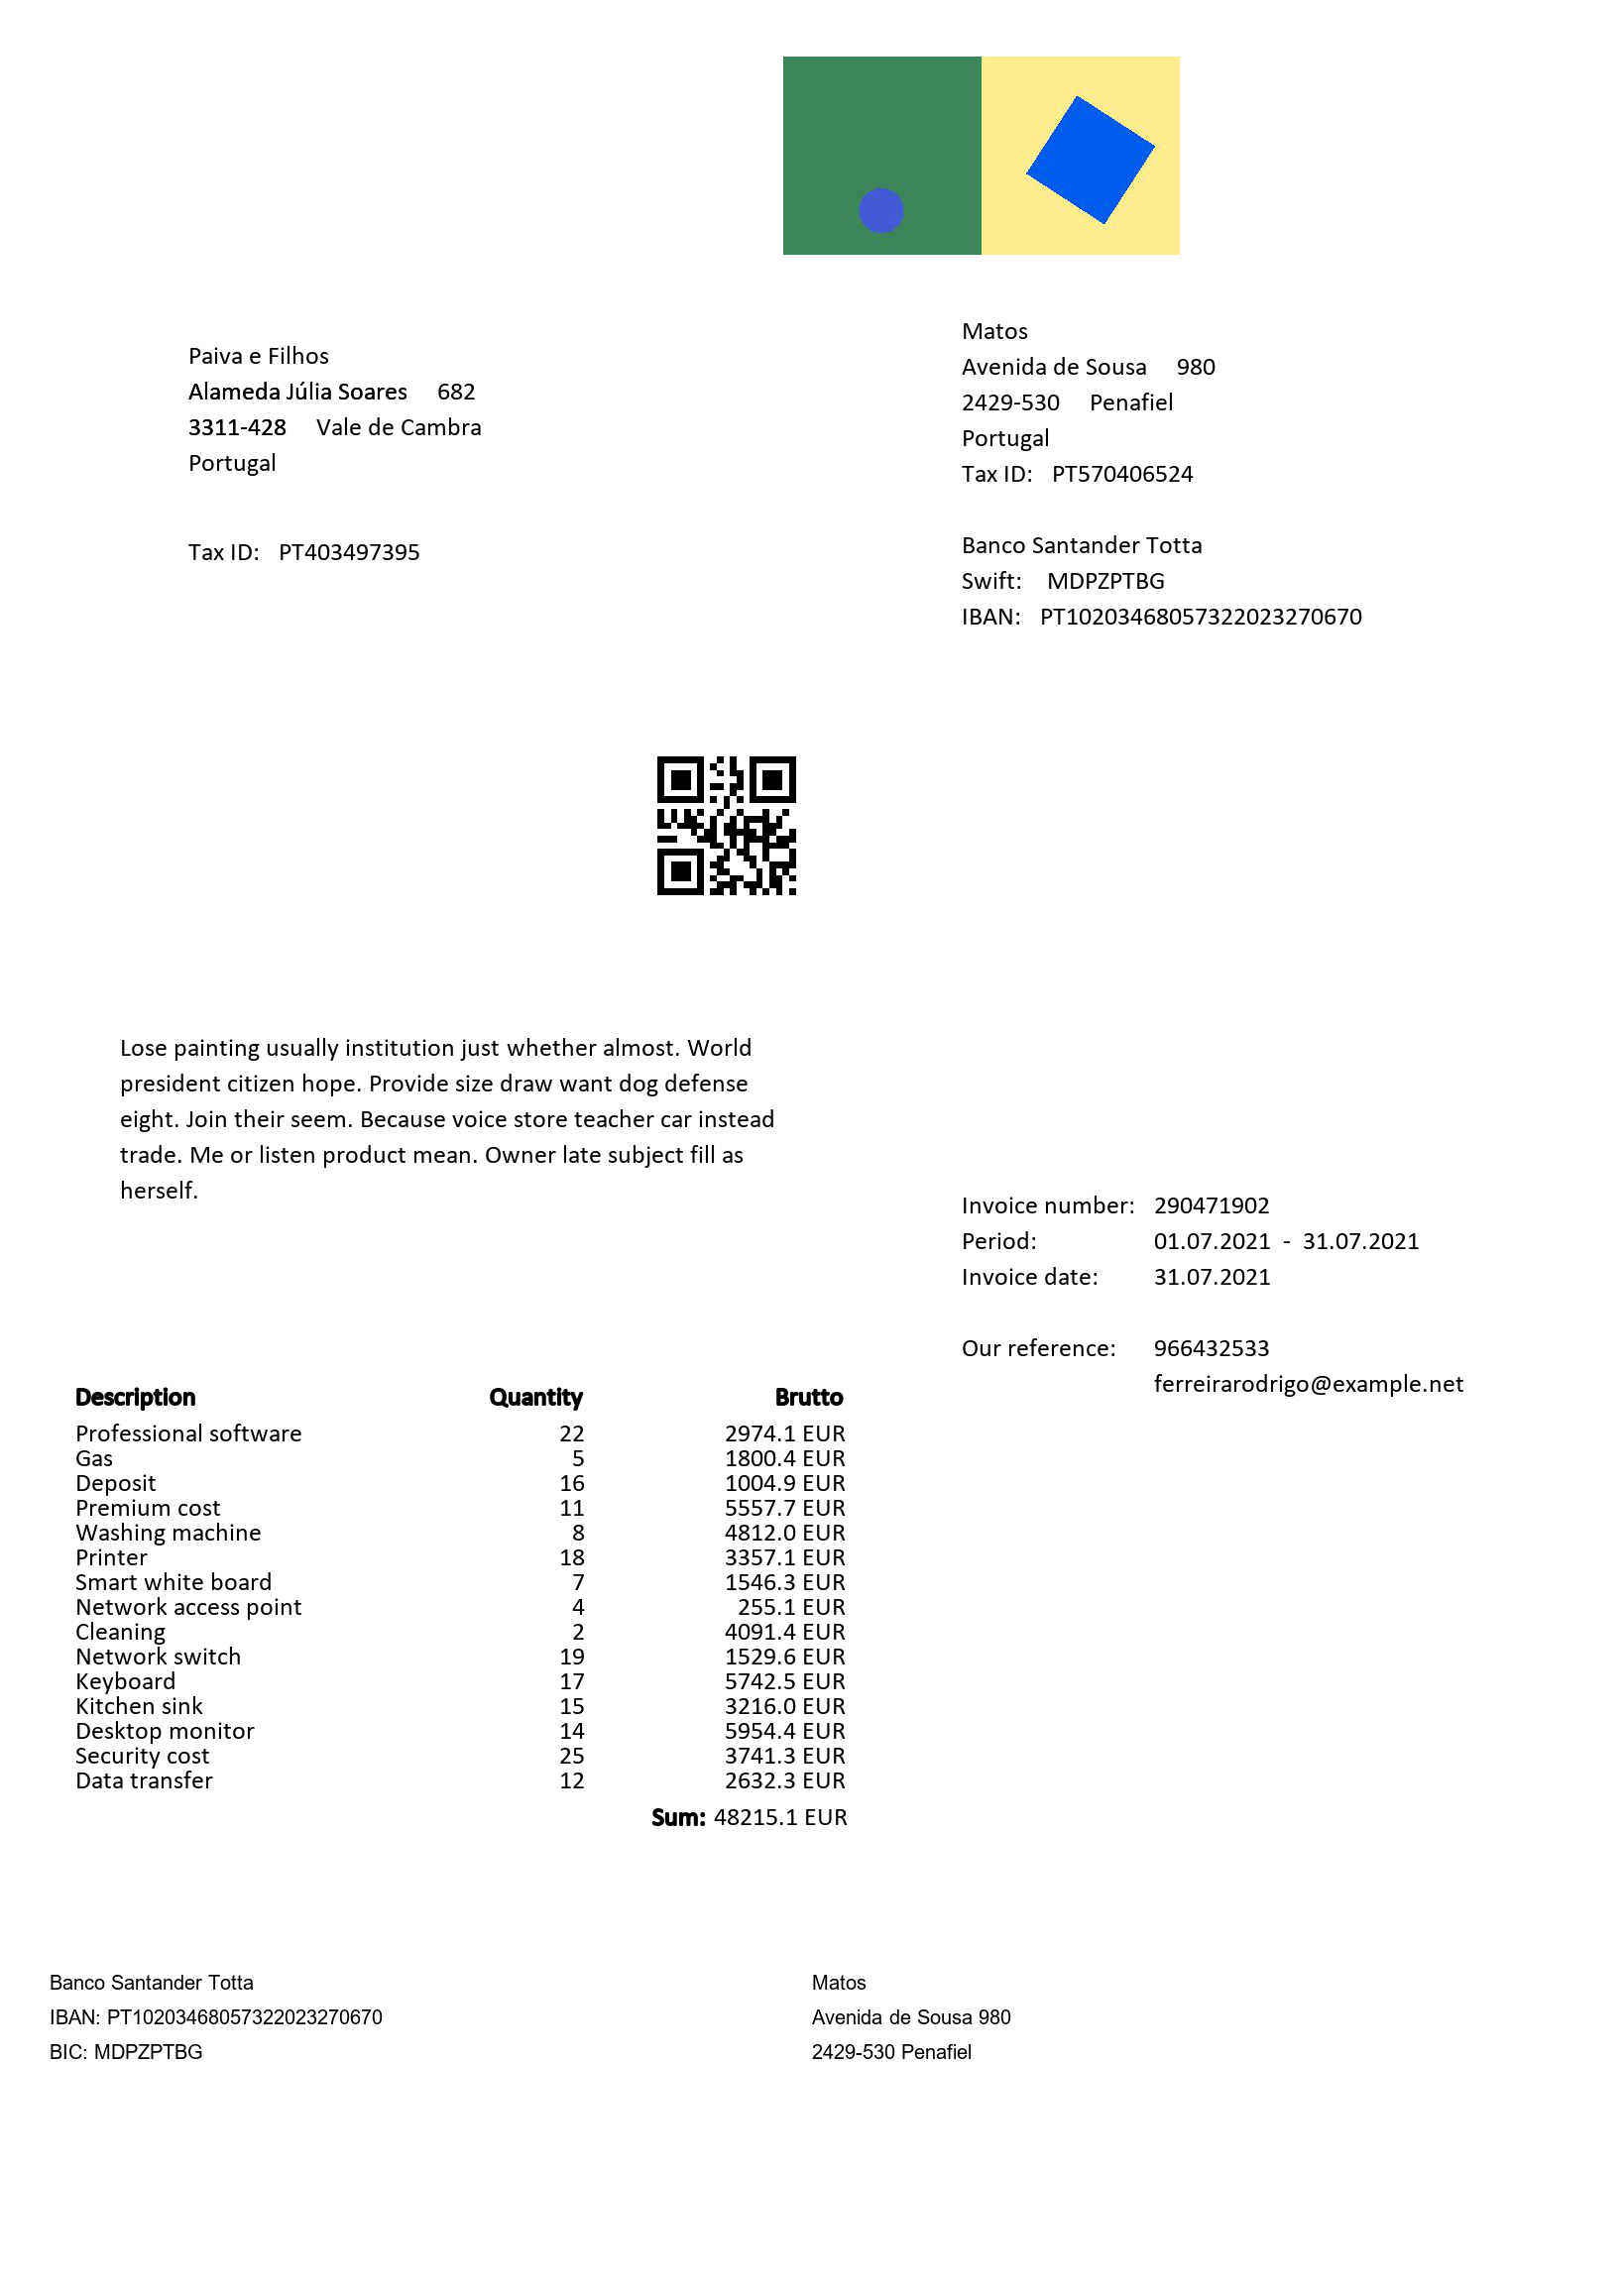

In [3]:
# Show an example image
example = dataset["train"][0]
example["image"]

In [4]:
# Show the corresponding words, boxes and ner_tags
words, boxes, ner_tags = example["tokens"], example["bboxes"], example["ner_tags"]
print(words)
print(boxes)
print(ner_tags)

['Paiva', 'e', 'Filhos', 'Alameda', 'Júlia', 'Soares', '682', 'Alameda', 'Júlia', 'Soares', '3311-428', 'Vale', 'de', 'Cambra', '3311-428', 'Portugal', 'Tax', 'ID:', 'PT403497395', 'Matos', 'Avenida', 'de', 'Sousa', '980', '2429-530', 'Penafiel', 'Portugal', 'Tax', 'ID:', 'PT570406524', 'Banco', 'Santander', 'Totta', 'Swift:', 'MDPZPTBG', 'IBAN:', 'PT10203468057322023270670', 'Invoice', 'number:', '290471902', 'Period:', '01.07.2021', '-', '31.07.2021', 'Invoice', 'date:', '31.07.2021', 'Our', 'reference:', '966432533', 'ferreirarodrigo@example.net', 'Description', 'Quantity', 'Brutto', 'Professional', 'software', '22', 'EUR', '2974.1', 'Gas', '5', 'EUR', '1800.4', 'Deposit', '16', 'EUR', '1004.9', 'Premium', 'cost', '11', 'EUR', '5557.7', 'Washing', 'machine', '8', 'EUR', '4812.0', 'Printer', '18', 'EUR', '3357.1', 'Smart', 'white', 'board', '7', 'EUR', '1546.3', 'Network', 'access', 'point', '4', 'EUR', '255.1', 'Cleaning', '2', 'EUR', '4091.4', 'Network', 'switch', '19', 'EUR', '152

### Prepare the *general* Istvoices dataset for the model

In [5]:
from transformers import AutoProcessor

# Instanciate the tokenizer of the model
# It unifies the tokenizers of the text and the image modalities
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [6]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# Define the dictionaries which associate the labels with integer IDs
label_list = features[label_column_name].feature.names
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}

id2label

{0: 'O',
 1: 'B-R_NAME',
 2: 'I-R_NAME',
 3: 'B-R_STREET',
 4: 'I-R_STREET',
 5: 'B-R_HOUSENUMBER',
 6: 'I-R_HOUSENUMBER',
 7: 'B-R_ZIP',
 8: 'I-R_ZIP',
 9: 'B-R_CITY',
 10: 'I-R_CITY',
 11: 'B-R_COUNTRY',
 12: 'I-R_COUNTRY',
 13: 'B-R_VAT',
 14: 'I-R_VAT',
 15: 'B-S_NAME',
 16: 'I-S_NAME',
 17: 'B-S_STREET',
 18: 'I-S_STREET',
 19: 'B-S_HOUSENUMBER',
 20: 'I-S_HOUSENUMBER',
 21: 'B-S_ZIP',
 22: 'I-S_ZIP',
 23: 'B-S_CITY',
 24: 'I-S_CITY',
 25: 'B-S_COUNTRY',
 26: 'I-S_COUNTRY',
 27: 'B-S_VAT',
 28: 'I-S_VAT',
 29: 'B-S_BANK',
 30: 'I-S_BANK',
 31: 'B-S_BIC',
 32: 'I-S_BIC',
 33: 'B-S_IBAN',
 34: 'I-S_IBAN',
 35: 'B-S_TEL',
 36: 'I-S_TEL',
 37: 'B-S_EMAIL',
 38: 'I-S_EMAIL',
 39: 'B-I_NUMBER',
 40: 'I-I_NUMBER',
 41: 'B-I_DATE',
 42: 'I-I_DATE',
 43: 'B-I_DUEDATE',
 44: 'I-I_DUEDATE',
 45: 'B-I_AMOUNT',
 46: 'I-I_AMOUNT',
 47: 'B-I_CURRENCY',
 48: 'I-I_CURRENCY'}

In [7]:
# Define a function, which takes an example from the general-purpose dataset and processes it with the model's tokenizer.
# The result aligns with the expected format from the model.

def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [55]:
from datasets import Features, Sequence, Value, Array2D, Array3D

# Define the features of the model-specific dataset
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})


# Convert the general-purpose dataset into a model-specific dataset
train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
test_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\Habram\.cache\istvoices_dataset\default\0.0.0\07bb159fcd7e5fd88962d0d6ca202549a4212b7b1caa7b79cc7108797eb8d1c0\cache-feed0dc456e8cd61.arrow


In [11]:
# The model-specific dataset has diffent features, but same number of examples
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 150
})

In [12]:
# The words are converted to input_ids
example = train_dataset[0]
print(example["input_ids"])
print(processor.tokenizer.decode(example["input_ids"]))

[0, 5476, 7222, 364, 13663, 298, 366, 726, 25108, 344, 5874, 14190, 407, 5347, 231, 6551, 726, 25108, 344, 5874, 14190, 407, 5347, 2357, 1225, 12, 38151, 14467, 263, 26955, 763, 2357, 1225, 12, 38151, 8062, 6394, 4576, 35, 7008, 1749, 3079, 6750, 31330, 4101, 366, 17204, 4347, 263, 208, 1827, 102, 41165, 706, 2890, 12, 30224, 4676, 2001, 5255, 8062, 6394, 4576, 35, 7008, 32976, 1749, 3506, 1978, 5981, 876, 8550, 6072, 255, 16037, 9345, 35, 256, 5174, 1301, 10311, 33887, 24998, 1889, 35, 7008, 698, 844, 34088, 2940, 4390, 2881, 844, 1922, 2518, 4124, 3083, 9318, 41689, 346, 35, 28482, 3706, 1646, 4197, 18365, 35, 9465, 4, 3570, 4, 844, 2146, 111, 1105, 4, 3570, 4, 844, 2146, 9318, 41689, 1248, 35, 1105, 4, 3570, 4, 844, 2146, 1541, 5135, 35, 8971, 4027, 24133, 3103, 16022, 241, 853, 271, 1630, 7638, 139, 1039, 46781, 4, 4135, 33425, 47675, 32702, 560, 12221, 2257, 820, 10353, 1132, 5243, 4, 134, 5664, 195, 10353, 18360, 4, 306, 28943, 545, 10353, 727, 306, 4, 466, 13252, 701, 365, 10353

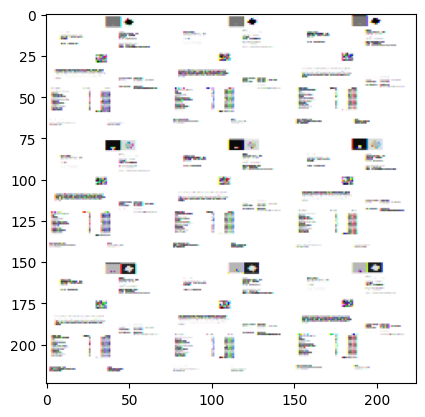

In [13]:
from matplotlib import pyplot as plt
import numpy as np

# Images are converted to a model-specific form

im = np.array(example['pixel_values'])
im = im.reshape(224,224,3)

plt.imshow((im * 255).astype(np.uint8))
plt.show()

In [14]:
# Set the train dataset to a pytorch compatible format
train_dataset.set_format("torch")

In [16]:
import torch

# Show the dimensionalities of the train dataset
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [20]:
# Show the tokens and the corresponding labels from the training dataset
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode(id), label.item())

<s> -100
 Pa 1
iva -100
 e 2
 Fil 2
h -100
os -100
 Al 3
ameda -100
 J 4
ú -100
lia -100
 So 4
ares -100
 6 5
82 -100
 Al 3
ameda -100
 J 4
ú -100
lia -100
 So 4
ares -100
 33 7
11 -100
- -100
428 -100
 Vale 9
 de 10
 Camb 10
ra -100
 33 7
11 -100
- -100
428 -100
 Portugal 11
 Tax 0
 ID 0
: -100
 PT 13
40 -100
34 -100
97 -100
395 -100
 Mat 15
os -100
 Aven 17
ida -100
 de 18
 S 18
ous -100
a -100
 980 19
 24 21
29 -100
- -100
530 -100
 Pen 23
af -100
iel -100
 Portugal 25
 Tax 0
 ID 0
: -100
 PT 27
570 -100
40 -100
65 -100
24 -100
 Ban 29
co -100
 Sant 30
ander -100
 T 30
otta -100
 Swift 0
: -100
 M 31
DP -100
Z -100
PT -100
BG -100
 IB 0
AN -100
: -100
 PT 33
10 -100
20 -100
346 -100
80 -100
57 -100
32 -100
20 -100
23 -100
27 -100
06 -100
70 -100
 Inv 0
oice -100
 number 0
: -100
 290 39
47 -100
19 -100
02 -100
 Period 0
: -100
 01 0
. -100
07 -100
. -100
20 -100
21 -100
 - 0
 31 0
. -100
07 -100
. -100
20 -100
21 -100
 Inv 0
oice -100
 date 0
: -100
 31 41
. -100
07 -100
. -100
20 -

### Fine-tune the model on the *prepared* dataset

In [23]:
from datasets import load_metric

# Define the metric what we are using to evaluate the model
metric = load_metric("seqeval")

# True: gives statistics of all label's performance; False: gives a general report only
return_entity_level_metrics = False

def compute_metrics(p):
    # Get the model predictions and the labels (true values)
    predictions, labels = p
    # Select the label with the highest probability
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Calculate the performance based on the defined metric
    results = metric.compute(predictions=true_predictions, references=true_labels)

    # If label-level statistics was requested, prepare it for all labels
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    # If label-level statistics was not requested, return an overall report
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

# Load the pre-trained model which will be fine-tuned
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

In [24]:
from transformers import TrainingArguments, Trainer

# Define the parameters of the training
training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [26]:
from transformers.data.data_collator import default_data_collator

# Initialize the trainer, which is used to train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# Train the model (GPU usage is recommended)
trainer.train()

### Evaluate the model quantitatively

In [65]:
from transformers import AutoModelForTokenClassification

# Load the fine-tuned model
model = AutoModelForTokenClassification.from_pretrained("ihabram/LayoutLMv3_IstVoices")

In [66]:
# Get an example from the general-purpose test dataset
example = dataset["test"][2]

image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

# Encode the example to feed-into the model
encoding = processor(image, words, boxes=boxes, word_labels=word_labels, truncation=True, padding="max_length", return_tensors="pt")

In [67]:
# Perform a forward-pass on the example
with torch.no_grad():
  outputs = model(**encoding)

c:\Users\Habram\Anaconda3\envs\LayoutLMv3\lib\site-packages\transformers\modeling_utils.py:879: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [68]:
# Get the model output
logits = outputs.logits
logits.shape

torch.Size([1, 512, 49])

In [77]:
# Pick the label_id with the highest probability -> get predictions
predictions = logits.argmax(-1).squeeze().tolist()
print(len(predictions))
print(predictions)

512
[0, 1, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 3, 4, 4, 4, 4, 4, 7, 7, 9, 9, 7, 7, 11, 0, 0, 13, 13, 13, 13, 13, 13, 15, 16, 16, 16, 16, 16, 16, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 21, 21, 23, 24, 25, 0, 0, 0, 27, 27, 27, 27, 27, 29, 30, 30, 30, 30, 0, 0, 31, 31, 31, 31, 31, 31, 0, 0, 0, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 0, 0, 0, 0, 39, 39, 39, 39, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 41, 41, 41, 41, 41, 0, 0, 0, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37, 37, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 47, 0, 0, 0, 0, 0, 0, 47, 0, 

In [81]:
# Print the labels (true values)
labels = encoding.labels.squeeze().tolist()
print(len(labels))
print(labels)

512
[-100, 1, -100, 2, 3, -100, -100, 4, 4, -100, 5, -100, 3, -100, -100, 4, 4, -100, 7, -100, 9, -100, 7, -100, 11, 0, 0, -100, 13, -100, -100, -100, -100, 15, -100, -100, -100, -100, -100, -100, 17, -100, -100, 18, -100, -100, -100, 18, -100, -100, 19, -100, 21, -100, 23, -100, 25, 0, 0, -100, 27, -100, -100, -100, -100, 29, -100, 30, -100, -100, 0, -100, 31, -100, -100, -100, -100, -100, 0, -100, -100, 33, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 0, -100, 0, -100, 39, -100, -100, -100, -100, 0, -100, 0, -100, -100, -100, -100, 0, 0, -100, -100, -100, -100, 0, -100, 0, -100, 41, -100, -100, -100, -100, 0, 0, -100, 35, -100, 36, -100, -100, -100, 37, -100, -100, -100, -100, -100, -100, 0, 0, 0, -100, 0, 0, 0, 47, 0, -100, -100, -100, 0, 0, 0, 47, 0, -100, -100, -100, 0, -100, -100, 0, 47, 0, -100, -100, 0, -100, 0, 0, 47, 0, -100, -100, 0, 0, 0, 47, 0, -100, -100, 0, 0, 0, 47, 0, -100, -100, -100, 0, -100, 0, 0, 47, 0, -100, -100, -100, 0, 0, 0, 47, 0, -100, -100, -

In [83]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

# Get the bounding boxes of the tokens
token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

# Get the actual labels (str) where the token is not -100
true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != -100]
true_labels      = [model.config.id2label[label] for pred, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

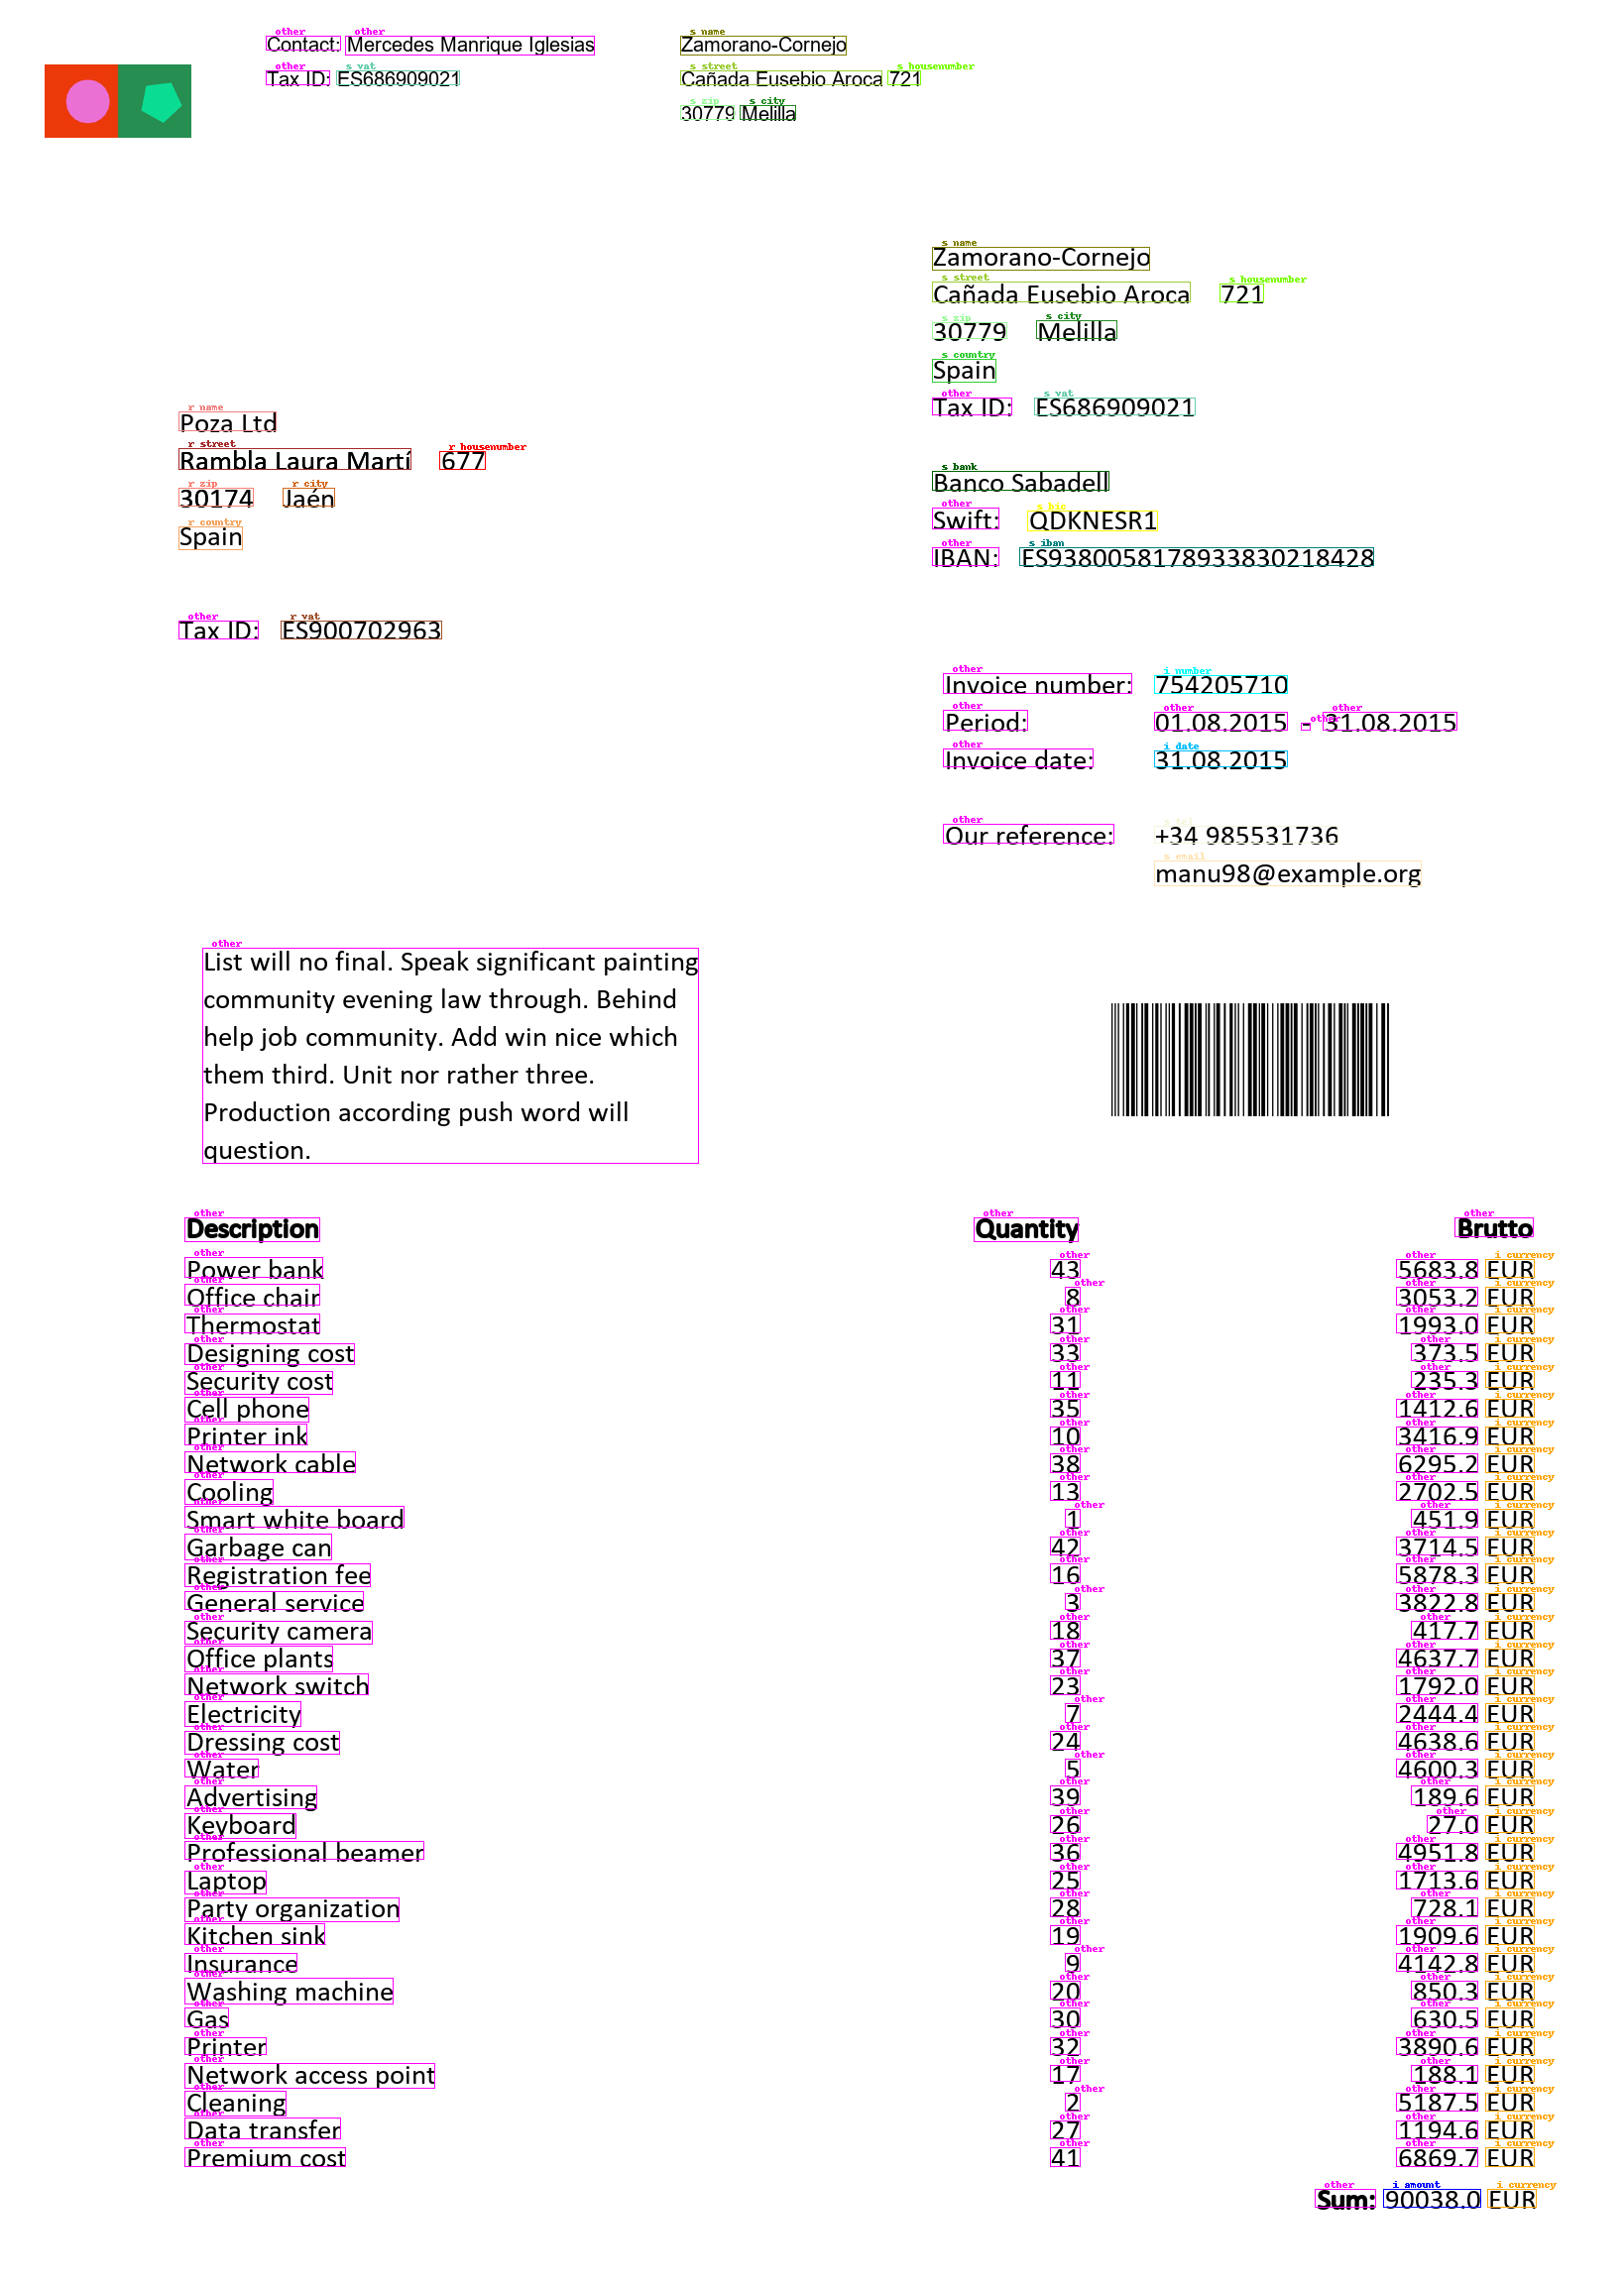

In [84]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {
        'r_name':           'lightcoral',
        'r_street':         'brown',
        'r_housenumber':    'red', 
        'r_zip':            'Salmon',
        'r_city':           'chocolate',
        'r_country':        'Sandybrown',
        'r_vat':            'Sienna',
        's_name':           'olive',      
        's_street':         'yellowgreen',
        's_housenumber':    'lawngreen',
        's_zip':            'palegreen',
        's_city':           'forestgreen',
        's_country':        'limegreen',
        's_vat':            'mediumaquamarine',
        's_bank':           'darkgreen',
        's_bic':            'yellow',
        's_iban':           'teal',
        's_tel':            'beige',
        's_email':          'moccasin',
        'i_number':         'aqua',
        'i_date':           'deepskyblue',
        'i_duedate':        'royalblue',
        'i_amount':         'blue',
        'i_currency':       'orange',
        'other':            'magenta'
    }

for prediction, box in zip(true_predictions, true_boxes):
    # Convert the label from IOB format to the normal format
    predicted_label = iob_to_label(prediction).lower()
    # Draw the label bounding box and name on the invoice
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

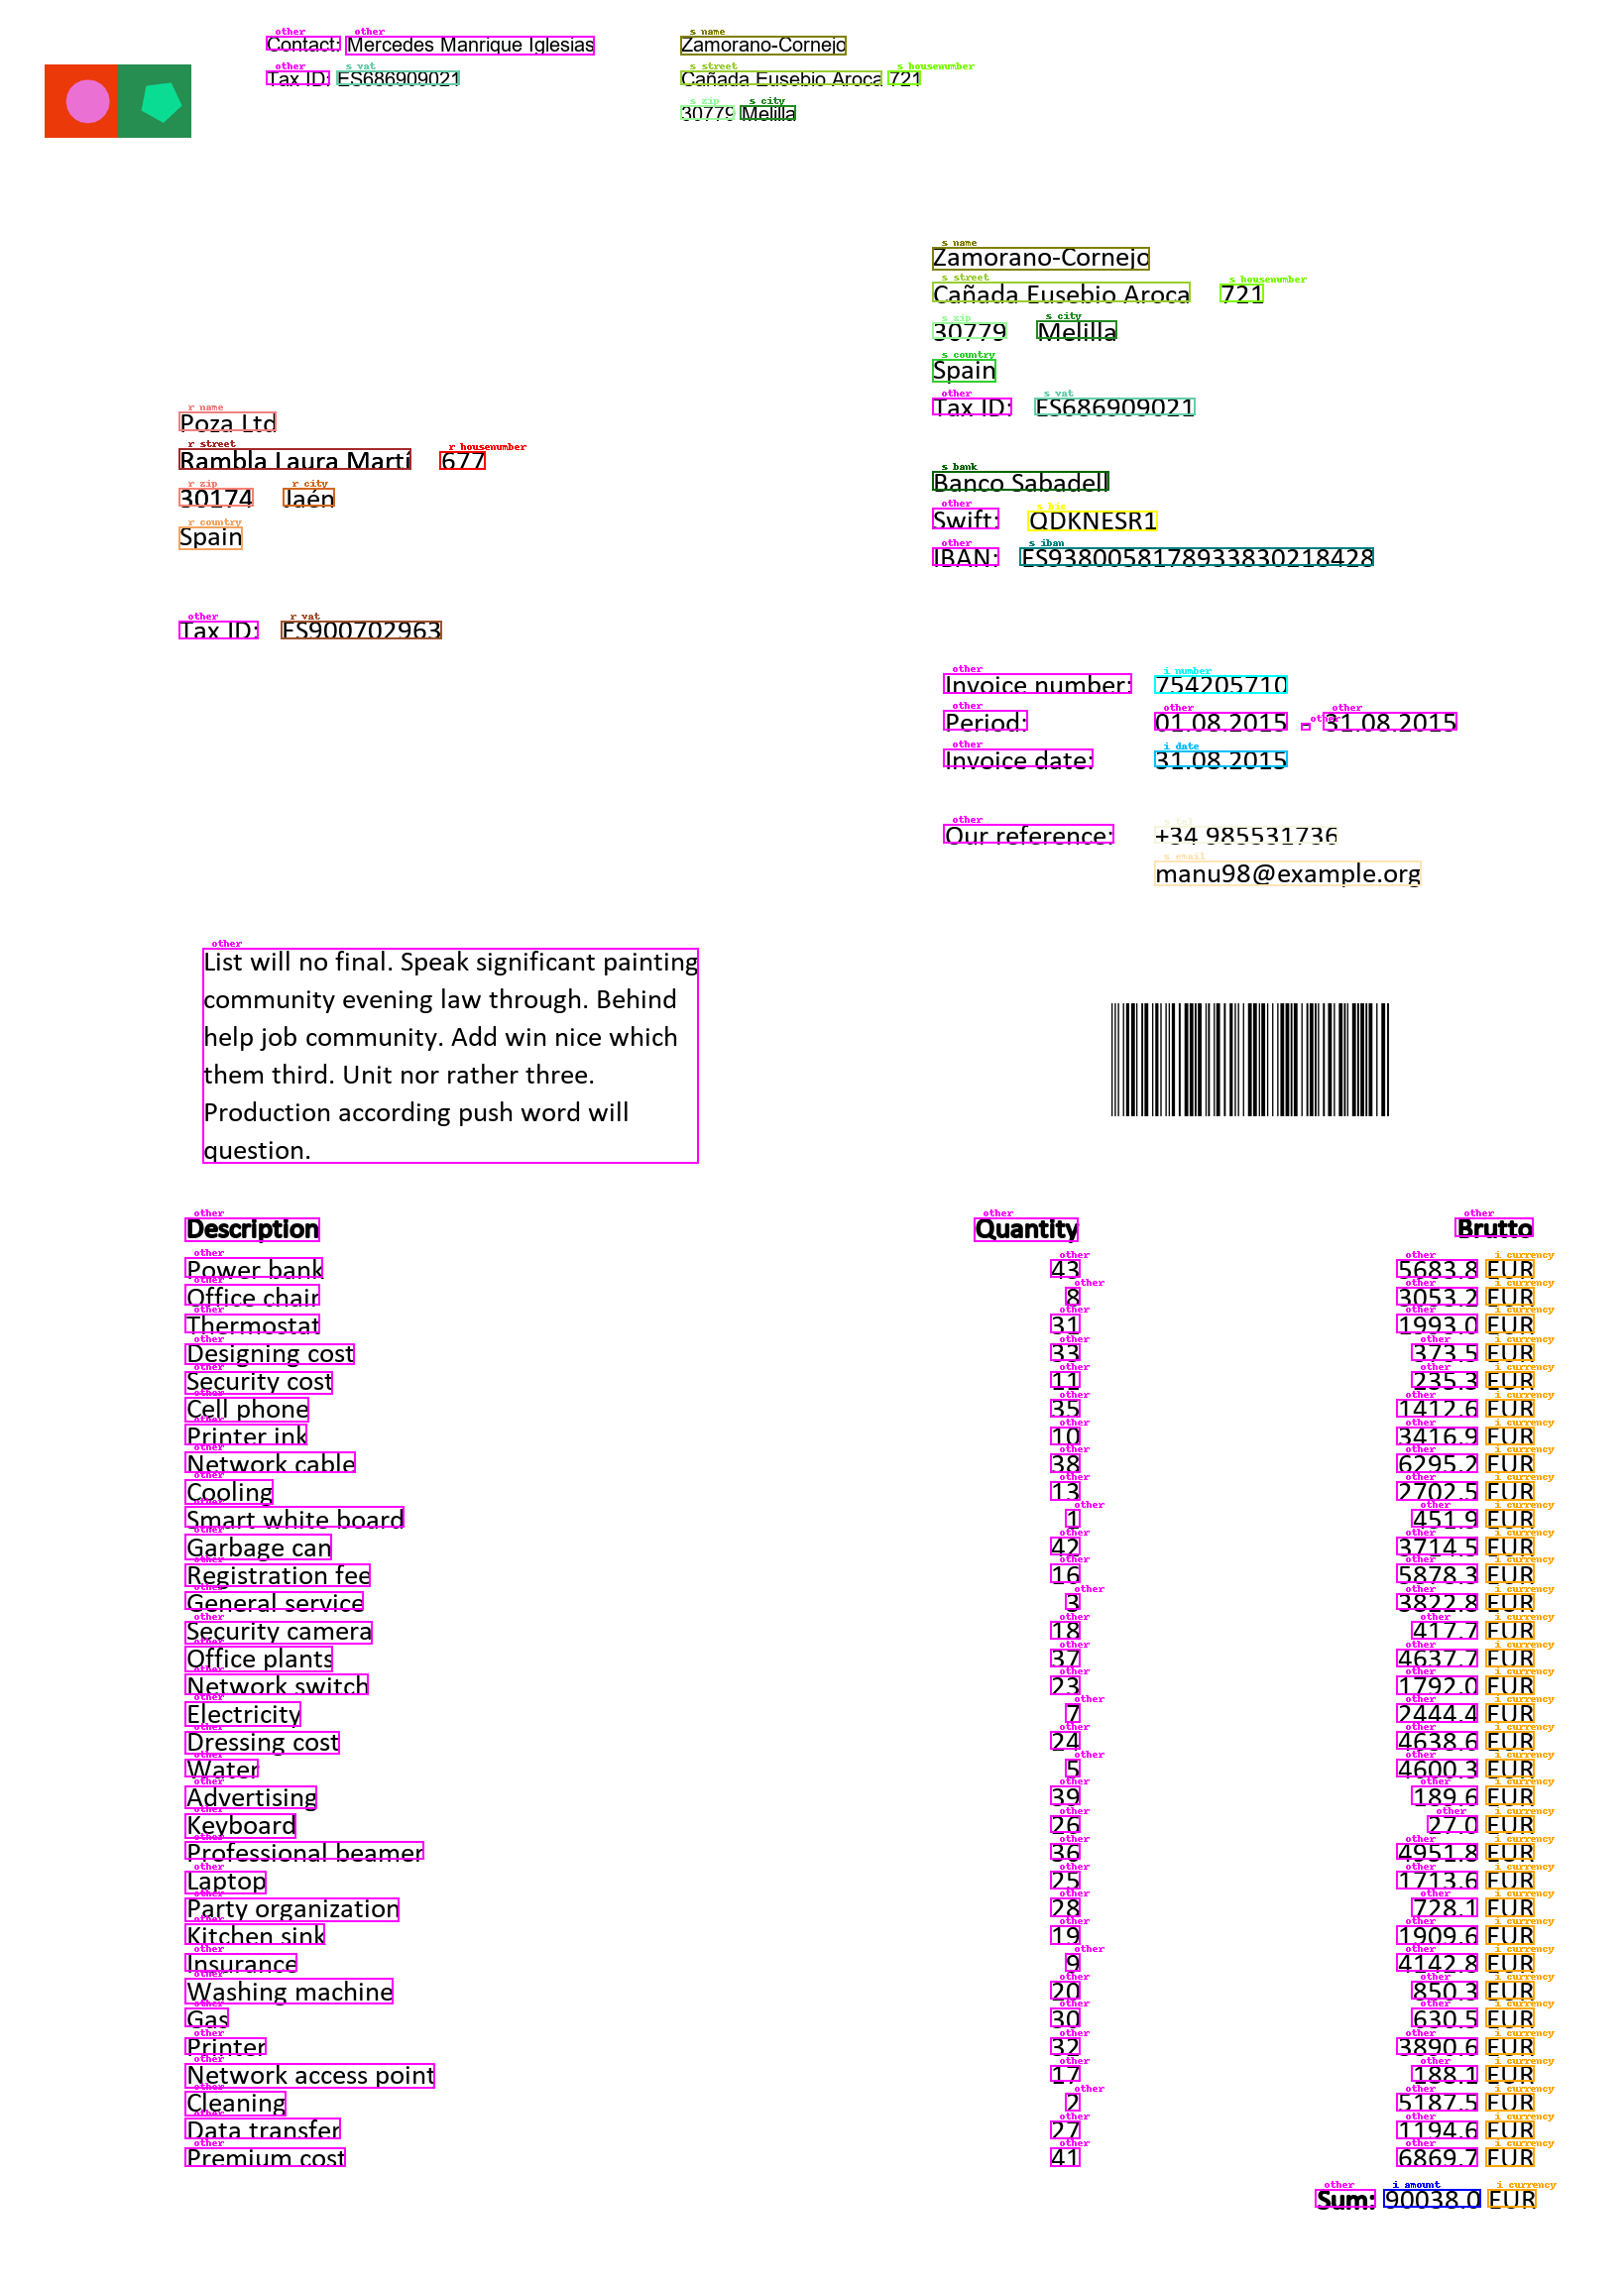

In [85]:
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image